## Load useful libraries

In [1]:
import pickle

from plotting_utilities import plot_basic_loss

## Specify which training run we are investigating

In [2]:
application_root_directory = '/home/emily/Desktop/projects/test/badass-data-science/badassdatascience/forecasting/deep_learning'
model_training_output_directory = application_root_directory + '/output/'

In [3]:
#training_run = '57f47108-380d-4e78-aeb9-7ebccd07ec65----afc4d8d7-e500-4a07-9063-4e46cdecea7e'
#training_run = '57f47108-380d-4e78-aeb9-7ebccd07ec65----3946abec-9ef2-43b8-a0dd-930e0a93471e'
training_run = '57f47108-380d-4e78-aeb9-7ebccd07ec65----eb540bb2-a954-49c0-addc-bcbf85cda01b'

In [4]:
history_file = model_training_output_directory + '/' + training_run + '_final_history_regressor.pickled'

## Load the training history

In [5]:
with open(history_file, 'rb') as f:
    history = pickle.load(f)

## Plot loss

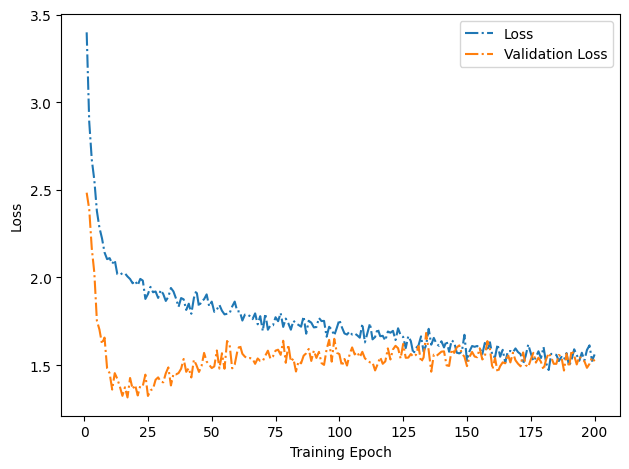

In [6]:
plot_basic_loss(history)